# Спортивный анализ данных. Платформа Kaggle. Домашнее задание №5

## Продолжим работу с данными, которые были использованы в ДЗ2 и 3, продолжим решать задачу обнаружения мошеннических транзакций, что позволит получить полное решение задачи / полный пайплайн.

## Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

### Загрузим датасет

In [1]:
from typing import List, Optional
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
!pip install catboost
import catboost as cb

     |████████████████████████████████| 67.3MB 48kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка датасета и вывод размерностей

In [69]:
data = pd.read_csv("/content/drive/MyDrive/assignment_2_train.csv")
lb = pd.read_csv("/content/drive/MyDrive/assignment_2_test.csv")

print("data.shape = {} rows, {} cols".format(*data.shape))
print("lb.shape = {} rows, {} cols".format(*lb.shape))

data.shape = 180000 rows, 394 cols
lb.shape = 100001 rows, 394 cols


In [70]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [ ]:
y_lb = lb['isFraud']
x_lb = lb.drop(columns=['isFraud'])

y = data['isFraud']
X = data.drop(columns=['isFraud'])

x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.7, shuffle=False, random_state=1,
)

categorical_features = x_train.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    x_train[feature] = x_train[feature].astype(str)
    x_valid[feature] = x_valid[feature].astype(str)
    x_lb[feature] = x_lb[feature].astype(str)

In [ ]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    #"task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 27,
    'learning_rate': 0.1,
    'task_type': 'GPU',
    'one_hot_max_size': 100
}

In [73]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6569442	test: 0.6862510	best: 0.6862510 (0)	total: 15.1ms	remaining: 15.1s
100:	learn: 0.8804725	test: 0.8568657	best: 0.8568658 (98)	total: 1.08s	remaining: 9.64s
200:	learn: 0.8883339	test: 0.8621852	best: 0.8625875 (199)	total: 2.05s	remaining: 8.14s
300:	learn: 0.8947853	test: 0.8668418	best: 0.8670131 (287)	total: 2.96s	remaining: 6.88s
400:	learn: 0.8994993	test: 0.8693831	best: 0.8693831 (400)	total: 3.88s	remaining: 5.8s
500:	learn: 0.9038059	test: 0.8713748	best: 0.8713748 (500)	total: 4.85s	remaining: 4.83s
600:	learn: 0.9070629	test: 0.8730857	best: 0.8730940 (599)	total: 5.83s	remaining: 3.87s
700:	learn: 0.9094498	test: 0.8750713	best: 0.8750713 (700)	total: 6.78s	remaining: 2.89s
800:	learn: 0.9121256	test: 0.8774047	best: 0.8774047 (800)	total: 7.75s	remaining: 1.93s
900:	learn: 0.9141153	test: 0.8777373	best: 0.8781245 (846)	total: 8.7s	remaining: 956ms
bestTest = 0.8781244755
bestIteration = 846
Shrink model to first 847 iterations.


In [74]:
train_pred = model_catb.predict_proba(x_train)
valid_pred = model_catb.predict_proba(x_valid)
lb_pred = model_catb.predict_proba(x_lb)

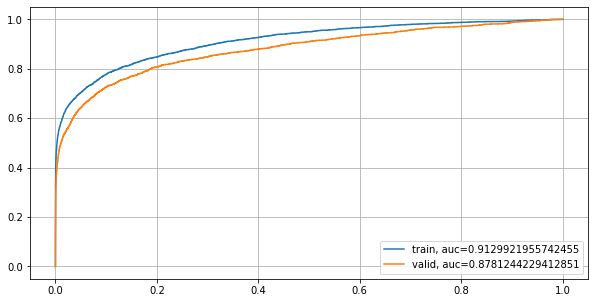

In [75]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [76]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train)[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid)[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9066051333064177, 0.9189482542409394)
Valid confidence interval = (0.8681079901907255, 0.8872280304676033)
Liderboard score = 0.8627113659276151


In [77]:
#fig = plt.figure(figsize=(15, 5))
#plt.suptitle("Bootstrap for evaluating validation stability", size=15)
#sns.distplot(train_scores,  color="green", bins=20, label='train')
#sns.distplot(valid_scores,  color="red", bins=20, label='valid')
#sns.distplot(lb_scores,  color="blue", bins=20, label='lb')
#plt.xlabel("sampel number", size=15)
#plt.legend()

## Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [78]:
data = pd.read_csv("/content/drive/MyDrive/assignment_2_train.csv")
lb = pd.read_csv("/content/drive/MyDrive/assignment_2_test.csv")

In [79]:
data['TransactionDT'] = pd.to_timedelta(data['TransactionDT'], unit='s')
base_date = pd.to_datetime('2017-12-01')
data['TransactionDT'] = data['TransactionDT'] + base_date

data["year"] = data["TransactionDT"].dt.year
data["month_of_year"] = data["TransactionDT"].dt.month
data["day_of_week"] = data["TransactionDT"].dt.weekday
data["week_of_year"] = data["TransactionDT"].dt.weekofyear
data["hour"] = data["TransactionDT"].dt.hour
data["day"] = data["TransactionDT"].dt.day

lb['TransactionDT'] = pd.to_timedelta(lb['TransactionDT'], unit='s')
base_date = pd.to_datetime('2017-12-01')
lb['TransactionDT'] = lb['TransactionDT'] + base_date
lb["year"] = lb["TransactionDT"].dt.year
lb["month_of_year"] = lb["TransactionDT"].dt.month
lb["day_of_week"] = lb["TransactionDT"].dt.weekday
lb["week_of_year"] = lb["TransactionDT"].dt.weekofyear
lb["hour"] = lb["TransactionDT"].dt.hour
lb["day"] = lb["TransactionDT"].dt.day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [80]:
data.drop(columns=['TransactionDT', 'TransactionID'], inplace=True)
lb.drop(columns=['TransactionDT', 'TransactionID'], inplace=True)

y_lb = lb['isFraud']
x_lb = lb.drop(columns=['isFraud'])

y = data['isFraud']
X = data.drop(columns=['isFraud'])

x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.7, shuffle=False, random_state=1,
)

categorical_features = x_train.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    x_train[feature] = x_train[feature].astype(str)
    x_valid[feature] = x_valid[feature].astype(str)
    x_lb[feature] = x_lb[feature].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6734327	test: 0.6576363	best: 0.6576363 (0)	total: 15.3ms	remaining: 15.3s
100:	learn: 0.8767213	test: 0.8547378	best: 0.8547382 (98)	total: 1.07s	remaining: 9.51s
200:	learn: 0.8864387	test: 0.8610479	best: 0.8615225 (189)	total: 2.05s	remaining: 8.16s
300:	learn: 0.8933287	test: 0.8646478	best: 0.8646478 (300)	total: 3.03s	remaining: 7.03s
400:	learn: 0.8982424	test: 0.8681763	best: 0.8682038 (394)	total: 3.92s	remaining: 5.86s
500:	learn: 0.9033496	test: 0.8700941	best: 0.8701233 (488)	total: 4.89s	remaining: 4.87s
600:	learn: 0.9071588	test: 0.8732176	best: 0.8732293 (590)	total: 5.79s	remaining: 3.84s
700:	learn: 0.9097266	test: 0.8742516	best: 0.8742696 (697)	total: 6.74s	remaining: 2.88s
800:	learn: 0.9122615	test: 0.8773643	best: 0.8773643 (800)	total: 7.73s	remaining: 1.92s
900:	learn: 0.9145708	test: 0.8799501	best: 0.8799885 (898)	total: 8.71s	remaining: 958ms
999:	learn: 0.9168071	test: 0.8812893	best: 0.8812893 (999)	total: 9.61s	remaining: 0us
bestTest = 0.881

In [82]:
train_pred = model_catb.predict_proba(x_train)
valid_pred = model_catb.predict_proba(x_valid)
lb_pred = model_catb.predict_proba(x_lb)

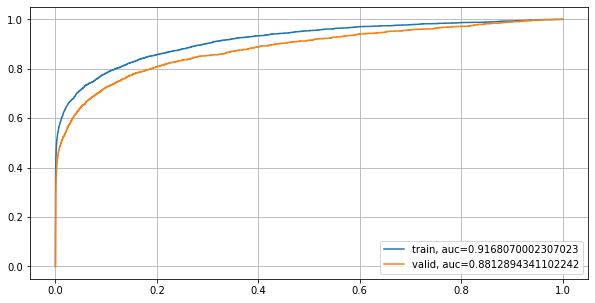

In [83]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [84]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train)[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid)[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9105117769658271, 0.9227946447718357)
Valid confidence interval = (0.8716406934772208, 0.8904157084460469)
Liderboard score = 0.8658167480470517


Вывод: обработка врменного признака повысило точность работы модели на 0.003

## Задание 2: сделать конкатенацию признаков
* card1 + card2;
* card1 + card2 + card_3 + card_5;
* card1 + card2 + card_3 + card_5 + addr1 + addr2

In [85]:
def create_concat_feature(data: pd.DataFrame, features: List[str]) -> pd.Series:
    """
    Возвращает признак (колонку), представляющую собой
    конкатенацию признаков features из датафрейма data

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Исходный датафрейм.

    features: List[str]
        Список с названием признаков, из которых будет создаваться новый.

    Returns
    -------
    new_feature: pd.Series
        Новый признак.

    """

    result = pd.Series(data='', index=data.index)
    for feature in features:
      result += data[feature].astype(str) + '|'
    return result

In [86]:
x_train['card1+card2'] = create_concat_feature(x_train, ['card1', 'card2'])
x_train['card1+card2+card3+card5'] = create_concat_feature(x_train, ['card1', 'card2', 'card3', 'card5'])
x_train['card1+card2+card3+card5+addr1+addr2'] = create_concat_feature(x_train, ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'])

x_valid['card1+card2'] = create_concat_feature(x_valid, ['card1', 'card2'])
x_valid['card1+card2+card3+card5'] = create_concat_feature(x_valid, ['card1', 'card2', 'card3', 'card5'])
x_valid['card1+card2+card3+card5+addr1+addr2'] = create_concat_feature(x_valid, ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'])

x_lb['card1+card2'] = create_concat_feature(x_lb, ['card1', 'card2'])
x_lb['card1+card2+card3+card5'] = create_concat_feature(x_lb, ['card1', 'card2', 'card3', 'card5'])
x_lb['card1+card2+card3+card5+addr1+addr2'] = create_concat_feature(x_lb, ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [87]:
categorical_features = x_lb.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    x_train[feature] = x_train[feature].astype(str)
    x_valid[feature] = x_valid[feature].astype(str)
    x_lb[feature] = x_lb[feature].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.7333154	test: 0.6375195	best: 0.6375195 (0)	total: 31.9ms	remaining: 31.8s
100:	learn: 0.8875181	test: 0.8455810	best: 0.8455810 (100)	total: 2.23s	remaining: 19.9s
200:	learn: 0.9015415	test: 0.8610812	best: 0.8610812 (199)	total: 4.37s	remaining: 17.4s
300:	learn: 0.9086696	test: 0.8680719	best: 0.8683884 (289)	total: 6.51s	remaining: 15.1s
400:	learn: 0.9129446	test: 0.8751015	best: 0.8753017 (393)	total: 8.54s	remaining: 12.8s
500:	learn: 0.9157544	test: 0.8781615	best: 0.8781615 (500)	total: 10.7s	remaining: 10.6s
600:	learn: 0.9180371	test: 0.8813086	best: 0.8813089 (599)	total: 12.8s	remaining: 8.5s
700:	learn: 0.9206099	test: 0.8839337	best: 0.8840717 (693)	total: 14.9s	remaining: 6.37s
800:	learn: 0.9221728	test: 0.8845528	best: 0.8849081 (745)	total: 17.1s	remaining: 4.24s
900:	learn: 0.9237798	test: 0.8865785	best: 0.8865945 (899)	total: 19.1s	remaining: 2.1s
999:	learn: 0.9249440	test: 0.8875079	best: 0.8875985 (975)	total: 21.1s	remaining: 0us
bestTest = 0.8875

In [89]:
train_pred = model_catb.predict_proba(x_train)
valid_pred = model_catb.predict_proba(x_valid)
lb_pred = model_catb.predict_proba(x_lb)

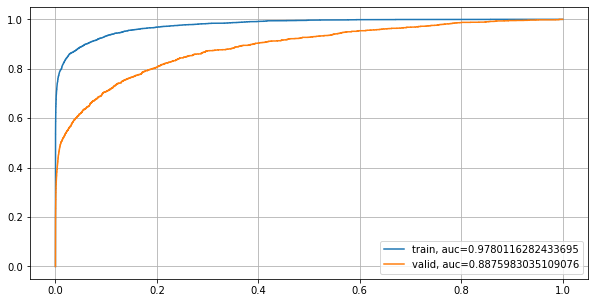

In [90]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [91]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train)[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid)[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.975437392964338, 0.9804821693310513)
Valid confidence interval = (0.8790229197197925, 0.8964030971604577)
Liderboard score = 0.8364646341043906


Вывод: конкатенация признаков ухудшило точность работы модели. На новых признаках модель переобучилась.

## Задание 3: Сделать FrequencyEncoder для признаков card1 - card6, addr1, addr2.

In [92]:
def frequency_encoder(data: pd.DataFrame,
                            features: List[str],
                            delete_old = False,
                            ) -> pd.DataFrame:
    """
    Уникальные значения в признаках features датафрейма
    data заменяются частотой их появления в этом датафрейме

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для преобразования признаков.

    features: List[str]
        Список с названием признаков, для которых произвести
        частотное кодирование.

    delete_old - флаг - удалять ли исходные признаки

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными (удаленными признаками).

    """
    for feature in features:
      stat = data[feature].value_counts().reset_index().rename(columns={'index': feature, feature: feature+'_cnt'})
      stat[feature+'_freq'] = stat[feature+'_cnt']/stat[feature+'_cnt'].sum()
      stat.drop(columns=[feature+'_cnt'], inplace=True)
      data = pd.merge(data, stat, how='left', on=feature)
      if delete_old == True:
        data.drop(columns=[feature], inplace=True)
    return data

In [93]:
data = pd.concat([x_train, x_valid])
columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']
data = frequency_encoder(data, columns, delete_old=False)
x_lb = frequency_encoder(x_lb, columns, delete_old=False)
x_train = data.iloc[:125999]
x_valid = data.iloc[125999:]
data.head(3)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,year,month_of_year,day_of_week,week_of_year,hour,day,card1+card2,card1+card2+card3+card5,card1+card2+card3+card5+addr1+addr2,card1_freq,card2_freq,card3_freq,card4_freq,card5_freq,card6_freq,addr1_freq,addr2_freq
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,nan,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,5,48,0,2,13926|nan|,13926|nan|150.0|142.0|,13926|nan|150.0|142.0|315.0|87.0|,0.000061,NaN,0.879737,0.013211,0.000274,0.317939,0.042773,0.982344
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,5,48,0,2,2755|404.0|,2755|404.0|150.0|102.0|,2755|404.0|150.0|102.0|325.0|87.0|,0.001244,0.006855,0.879737,0.302783,0.054723,0.317939,0.080004,0.982344
2,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,nan,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,5,48,0,2,4663|490.0|,4663|490.0|150.0|166.0|,4663|490.0|150.0|166.0|330.0|87.0|,0.001428,0.061413,0.879737,0.657194,0.080269,0.681922,0.046205,0.982344


In [94]:
categorical_feature_names.remove('card1+card2')
categorical_feature_names.remove('card1+card2+card3+card5')
categorical_feature_names.remove('card1+card2+card3+card5+addr1+addr2')
bad_features = ['card1+card2',	'card1+card2+card3+card5',	'card1+card2+card3+card5+addr1+addr2']

In [95]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train.drop(columns=bad_features), y_train, eval_set=[(x_valid.drop(columns=bad_features), y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6734327	test: 0.6576363	best: 0.6576363 (0)	total: 15.5ms	remaining: 15.4s
100:	learn: 0.8766174	test: 0.8546659	best: 0.8546841 (96)	total: 1.14s	remaining: 10.2s
200:	learn: 0.8868750	test: 0.8599334	best: 0.8599334 (200)	total: 2.13s	remaining: 8.45s
300:	learn: 0.8959241	test: 0.8662692	best: 0.8662692 (300)	total: 3.09s	remaining: 7.17s
400:	learn: 0.9005053	test: 0.8683697	best: 0.8684644 (393)	total: 4.08s	remaining: 6.09s
500:	learn: 0.9043432	test: 0.8709120	best: 0.8709120 (500)	total: 5s	remaining: 4.98s
600:	learn: 0.9079051	test: 0.8731821	best: 0.8731821 (600)	total: 6s	remaining: 3.98s
700:	learn: 0.9103289	test: 0.8752802	best: 0.8753095 (697)	total: 6.96s	remaining: 2.97s
800:	learn: 0.9123986	test: 0.8771481	best: 0.8771618 (798)	total: 7.9s	remaining: 1.96s
900:	learn: 0.9147204	test: 0.8793283	best: 0.8793705 (896)	total: 8.87s	remaining: 975ms
999:	learn: 0.9165937	test: 0.8817821	best: 0.8817902 (995)	total: 9.81s	remaining: 0us
bestTest = 0.8817901909

In [96]:
train_pred = model_catb.predict_proba(x_train.drop(columns=bad_features))
valid_pred = model_catb.predict_proba(x_valid.drop(columns=bad_features))
lb_pred = model_catb.predict_proba(x_lb.drop(columns=bad_features))

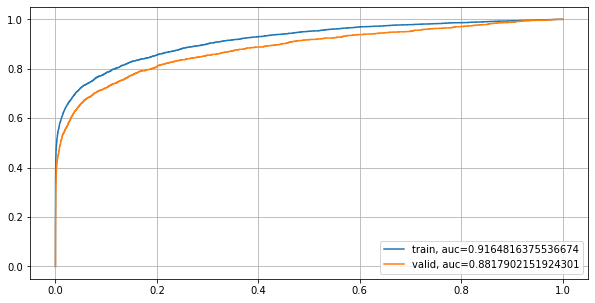

In [97]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [98]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train.drop(columns=bad_features))[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid.drop(columns=bad_features))[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9102223693382371, 0.922512710682003)
Valid confidence interval = (0.8720221200041807, 0.890576866212448)
Liderboard score = 0.8670819988144947


Вывод: обработка признаков улучшила точность модели на 0.001

## Задание 4: Создать признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [105]:
def add_stat_features(data: pd.DataFrame,
                            groupby_features: List[str],
                            feature_to_stat: str
                            ) -> pd.DataFrame:
    """
    Вычисляет новые признаки (feature_to_stat/(среднее значение/стандартное отклоненеие для feature_to_stat))  
    с группированием по признакам groupby_features датафрейма data.


    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для создания признаков.

    groupby_features: List[str]
        Список с названием признаков, по которым производится группировка.

    feature_to_stat - признак, на основе которого будут вычисляться статистики

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными признаками.

    """
    for feature in groupby_features:
      stat = data.groupby(feature).agg({feature_to_stat: [np.mean, np.std]}).reset_index()
      stat.columns = [feature, 'mean_' + feature_to_stat, 'std_' + feature_to_stat]
      stat[feature_to_stat+'_'+feature+'_stat'] = stat['mean_' + feature_to_stat]/stat['std_' + feature_to_stat]
      stat.drop(columns=['mean_' + feature_to_stat, 'std_' + feature_to_stat], inplace=True)
      data = pd.merge(data, stat, on=feature, how='left')
      data[feature+'_stat'] = data[feature_to_stat] / data[feature_to_stat+'_'+feature+'_stat']
    return data

In [106]:
groupby_features = ['card1','card2','card3','card4','card5','card6','addr1','addr2',
                    'card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2']
data = pd.concat([x_train, x_valid])

data = add_stat_features(data, groupby_features=groupby_features, feature_to_stat='TransactionAmt')
x_lb = add_stat_features(x_lb, groupby_features=groupby_features, feature_to_stat='TransactionAmt')

#data.drop(columns=['card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2'], inplace=True)
#lb.drop(columns=['card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2'], inplace=True)

x_train = data.iloc[:125999]
x_valid = data.iloc[125999:]

In [107]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train.drop(columns=bad_features), y_train, eval_set=[(x_valid.drop(columns=bad_features), y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6734327	test: 0.6576363	best: 0.6576363 (0)	total: 15.5ms	remaining: 15.5s
100:	learn: 0.8790240	test: 0.8561936	best: 0.8561936 (100)	total: 1.07s	remaining: 9.57s
200:	learn: 0.8878806	test: 0.8630585	best: 0.8630585 (200)	total: 2.01s	remaining: 7.98s
300:	learn: 0.8962606	test: 0.8661961	best: 0.8662019 (299)	total: 2.92s	remaining: 6.78s
400:	learn: 0.9009526	test: 0.8694460	best: 0.8694806 (398)	total: 3.85s	remaining: 5.75s
500:	learn: 0.9049004	test: 0.8721395	best: 0.8724090 (488)	total: 4.87s	remaining: 4.85s
600:	learn: 0.9074336	test: 0.8736686	best: 0.8737066 (592)	total: 5.77s	remaining: 3.83s
700:	learn: 0.9100474	test: 0.8765931	best: 0.8765931 (700)	total: 6.72s	remaining: 2.87s
800:	learn: 0.9129595	test: 0.8786175	best: 0.8786175 (800)	total: 7.71s	remaining: 1.91s
900:	learn: 0.9149648	test: 0.8808670	best: 0.8809057 (898)	total: 8.65s	remaining: 950ms
999:	learn: 0.9170019	test: 0.8830609	best: 0.8830609 (999)	total: 9.57s	remaining: 0us
bestTest = 0.88

In [108]:
train_pred = model_catb.predict_proba(x_train.drop(columns=bad_features))
valid_pred = model_catb.predict_proba(x_valid.drop(columns=bad_features))
lb_pred = model_catb.predict_proba(x_lb.drop(columns=bad_features))

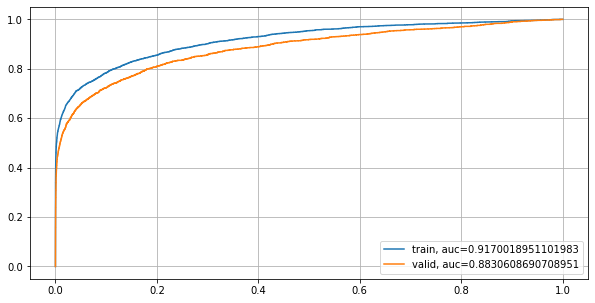

In [109]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [110]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train.drop(columns=bad_features))[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid.drop(columns=bad_features))[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9107071800987113, 0.9229890708619648)
Valid confidence interval = (0.8735119399580694, 0.8920106162089712)
Liderboard score = 0.864601107401547


Вывод: на валидации результат улучшился, а на лидерборде - ухудшился. Возможно переобучение на валидационной выборке

## Задание 5: Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [111]:
groupby_features = ['card1','card2','card3','card4','card5','card6','addr1','addr2',
                    'card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2']

data = pd.concat([x_train, x_valid])

data = add_stat_features(data, groupby_features=groupby_features, feature_to_stat='D15')
x_lb = add_stat_features(x_lb, groupby_features=groupby_features, feature_to_stat='D15')

x_train = data.iloc[:125999]
x_valid = data.iloc[125999:]
#data.drop(columns=['card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2'], inplace=True)
#lb.drop(columns=['card1+card2', 'card1+card2+card3+card5', 'card1+card2+card3+card5+addr1+addr2'], inplace=True)

In [112]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train.drop(columns=bad_features), y_train, eval_set=[(x_valid.drop(columns=bad_features), y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6734327	test: 0.6576363	best: 0.6576363 (0)	total: 15.8ms	remaining: 15.8s
100:	learn: 0.8763366	test: 0.8544645	best: 0.8544747 (93)	total: 1.11s	remaining: 9.91s
200:	learn: 0.8846852	test: 0.8592085	best: 0.8593178 (190)	total: 2.14s	remaining: 8.5s
300:	learn: 0.8943070	test: 0.8646220	best: 0.8646220 (300)	total: 3.1s	remaining: 7.2s
400:	learn: 0.8992400	test: 0.8691216	best: 0.8691561 (358)	total: 4.02s	remaining: 6s
500:	learn: 0.9036724	test: 0.8720454	best: 0.8720454 (500)	total: 4.93s	remaining: 4.91s
600:	learn: 0.9072204	test: 0.8748295	best: 0.8749220 (591)	total: 5.86s	remaining: 3.89s
700:	learn: 0.9099557	test: 0.8768017	best: 0.8769052 (698)	total: 6.79s	remaining: 2.9s
800:	learn: 0.9126585	test: 0.8789162	best: 0.8789162 (800)	total: 7.72s	remaining: 1.92s
900:	learn: 0.9150513	test: 0.8803412	best: 0.8803412 (900)	total: 8.67s	remaining: 952ms
999:	learn: 0.9176612	test: 0.8824760	best: 0.8824760 (999)	total: 9.67s	remaining: 0us
bestTest = 0.8824759722

In [113]:
train_pred = model_catb.predict_proba(x_train.drop(columns=bad_features))
valid_pred = model_catb.predict_proba(x_valid.drop(columns=bad_features))
lb_pred = model_catb.predict_proba(x_lb.drop(columns=bad_features))

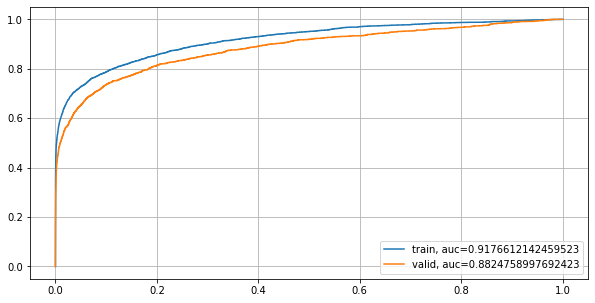

In [114]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [115]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train.drop(columns=bad_features))[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid.drop(columns=bad_features))[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9113481060046793, 0.9235035334865145)
Valid confidence interval = (0.8724262026641665, 0.8916014853908777)
Liderboard score = 0.8607895967667208


Вывод: обработка признаков привело к ухудшению результата как на валидации, так и надерборде.

## Задание 6: выделить дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создать отдельных признак - логарифм от TransactionAmt

In [116]:
def log_transform(data: pd.DataFrame,
                            feature_to_transform: str,
                            delete_old = False,
                            ) -> pd.DataFrame:
    """
    Создает 3 новых признака в датафрейме data на основе 
    признака feature_to_transform: целая часть признака,
    дробная часть признака и логарифм от признака


    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для создания признаков.

    feature_to_transform - признак, на основе которого будут вычисляться другие признаки

    delete_old - удалять ли исходный признак

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными признаками.

    """
    data[feature_to_transform + '_left'] = data[feature_to_transform].apply(np.floor)
    data[feature_to_transform + '_right'] = data[feature_to_transform] - data[feature_to_transform + '_left']
    data['log_' + feature_to_transform] = data[feature_to_transform].apply(np.log)
    if delete_old == True:
      data.drop(columns=[feature_to_transform], inplace=True)

    return data

In [117]:
x_train = log_transform(x_train, 'TransactionAmt', delete_old=True)
x_valid = log_transform(x_valid, 'TransactionAmt', delete_old=True)
x_lb = log_transform(x_lb, 'TransactionAmt', delete_old=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [118]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train.drop(columns=bad_features), y_train, eval_set=[(x_valid.drop(columns=bad_features), y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6834284	test: 0.6805373	best: 0.6805373 (0)	total: 15.3ms	remaining: 15.3s
100:	learn: 0.8786111	test: 0.8622825	best: 0.8624734 (94)	total: 1.1s	remaining: 9.8s
200:	learn: 0.8868717	test: 0.8660442	best: 0.8660552 (179)	total: 2.03s	remaining: 8.09s
300:	learn: 0.8931612	test: 0.8712050	best: 0.8712050 (300)	total: 3.01s	remaining: 7s
400:	learn: 0.8979465	test: 0.8733134	best: 0.8735085 (377)	total: 3.94s	remaining: 5.88s
500:	learn: 0.9030932	test: 0.8763840	best: 0.8763840 (500)	total: 4.87s	remaining: 4.86s
600:	learn: 0.9067720	test: 0.8785569	best: 0.8786000 (597)	total: 5.81s	remaining: 3.86s
700:	learn: 0.9094098	test: 0.8804280	best: 0.8805061 (699)	total: 6.75s	remaining: 2.88s
800:	learn: 0.9120442	test: 0.8823907	best: 0.8824525 (791)	total: 7.67s	remaining: 1.9s
900:	learn: 0.9143376	test: 0.8831729	best: 0.8832070 (892)	total: 8.6s	remaining: 945ms
999:	learn: 0.9166302	test: 0.8842059	best: 0.8842934 (975)	total: 9.56s	remaining: 0us
bestTest = 0.884293437


In [119]:
train_pred = model_catb.predict_proba(x_train.drop(columns=bad_features))
valid_pred = model_catb.predict_proba(x_valid.drop(columns=bad_features))
lb_pred = model_catb.predict_proba(x_lb.drop(columns=bad_features))

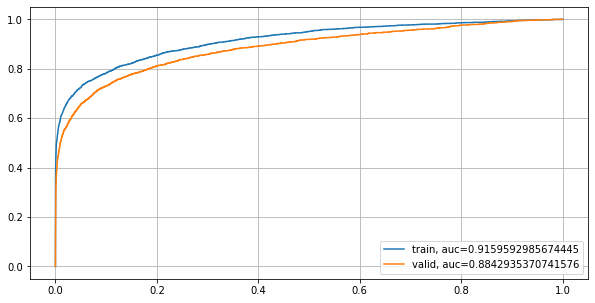

In [120]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [121]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train.drop(columns=bad_features))[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid.drop(columns=bad_features))[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9094349265653119, 0.9220229534812125)
Valid confidence interval = (0.8742778414209784, 0.893127774907297)
Liderboard score = 0.8647080858880251


Вывод: обработка признаков привело к повышению точности работы модели на 0.002

## Задание 7 (опция): выполнить предварительную подготовку / очистку признаков P_emaildomain и R_emaildomain (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.

In [122]:
#data['P_emaildomain'] = data['P_emaildomain'].astype(str)
#data['R_emaildomain'] = data['R_emaildomain'].astype(str)

In [123]:
x_train['P_emaildomain'] = x_train['P_emaildomain'].apply(lambda x: x.split('.')[-1])
x_train['R_emaildomain'] = x_train['R_emaildomain'].apply(lambda x: x.split('.')[-1])

x_valid['P_emaildomain'] = x_valid['P_emaildomain'].apply(lambda x: x.split('.')[-1])
x_valid['R_emaildomain'] = x_valid['R_emaildomain'].apply(lambda x: x.split('.')[-1])

x_lb['P_emaildomain'] = x_lb['P_emaildomain'].apply(lambda x: x.split('.')[-1])
x_lb['R_emaildomain'] = x_lb['R_emaildomain'].apply(lambda x: x.split('.')[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [124]:
data = pd.concat([x_train, x_valid])

columns = ['P_emaildomain', 'R_emaildomain']

data = frequency_encoder(data, columns, delete_old=True)
x_lb = frequency_encoder(x_lb, columns, delete_old=True)

x_train = data.iloc[:125999]
x_valid = data.iloc[125999:]

In [125]:
categorical_feature_names.remove('P_emaildomain')
categorical_feature_names.remove('R_emaildomain')

In [126]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train.drop(columns=bad_features), y_train, eval_set=[(x_valid.drop(columns=bad_features), y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.5948537	test: 0.6229293	best: 0.6229293 (0)	total: 14.8ms	remaining: 14.7s
100:	learn: 0.8783338	test: 0.8582378	best: 0.8586816 (95)	total: 1.08s	remaining: 9.59s
200:	learn: 0.8879206	test: 0.8638932	best: 0.8638932 (200)	total: 2s	remaining: 7.94s
300:	learn: 0.8953887	test: 0.8678872	best: 0.8679808 (274)	total: 2.93s	remaining: 6.8s
400:	learn: 0.9000610	test: 0.8723311	best: 0.8723346 (399)	total: 3.85s	remaining: 5.76s
500:	learn: 0.9044666	test: 0.8746336	best: 0.8746336 (500)	total: 4.79s	remaining: 4.77s
600:	learn: 0.9082481	test: 0.8775759	best: 0.8775759 (600)	total: 5.78s	remaining: 3.83s
700:	learn: 0.9112694	test: 0.8801849	best: 0.8802882 (692)	total: 6.71s	remaining: 2.86s
800:	learn: 0.9137916	test: 0.8819454	best: 0.8822129 (776)	total: 7.61s	remaining: 1.89s
900:	learn: 0.9165703	test: 0.8846111	best: 0.8846222 (897)	total: 8.52s	remaining: 936ms
999:	learn: 0.9192104	test: 0.8863644	best: 0.8863644 (999)	total: 9.47s	remaining: 0us
bestTest = 0.8863644

In [127]:
train_pred = model_catb.predict_proba(x_train.drop(columns=bad_features))
valid_pred = model_catb.predict_proba(x_valid.drop(columns=bad_features))
lb_pred = model_catb.predict_proba(x_lb.drop(columns=bad_features))

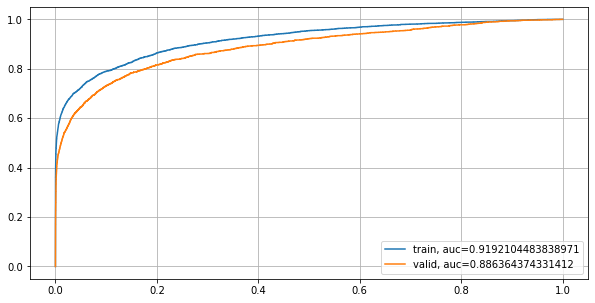

In [128]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [129]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb.predict_proba(x_train.drop(columns=bad_features))[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb.predict_proba(x_valid.drop(columns=bad_features))[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9130498009026564, 0.9250350494456865)
Valid confidence interval = (0.8768597100578368, 0.8951208701434852)
Liderboard score = 0.8642328231607006


Вывод: обработка признака улучшило качество модели на валидации без улучшения качества на лидерборде. Возможно переобучение под валидационную выборку